In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from dataset import feature_engineering, custom_train_test_split, make_dataset

import os

dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

from datetime import date, datetime, timezone, timedelta

exp_day = str(date.today())

KST = timezone(timedelta(hours=9))
time_record = datetime.now(KST)
_day = str(time_record)[:10]
_time = str(time_record.time())[:8]
now_time = _day+'_'+_time


In [2]:
train_data = pd.read_pickle('/opt/ml/level2-dkt-level2-recsys-08/data_pkl/train_data.pkl')

In [6]:
train, valid = custom_train_test_split(train_data)
y_train, x_train, y_valid, x_valid = make_dataset(train, valid)

cate_cols = [
            'assessmentItemID',
            'testId',
            'KnowledgeTag',
            'hour',
            'dow',
            # 'i_head',
            # 'i_mid',
            # 'i_tail',
]
cont_cols = [                        
            'user_correct_answer',
            'user_total_answer',
            'user_acc',            
            't_elapsed',            
            'cum_correct',
            'last_problem',
            'head_term',
            # 'left_asymptote',
            'elo_prob',
            'pkt',
            'u_head_mean',
            'u_head_count',
            'u_head_std',
            'u_head_elapsed',
            'i_mid_elapsed',
            'i_mid_mean',
            'i_mid_std',
            'i_mid_sum',
            'i_mid_count',
            'i_mid_tag_count',
            # 'assessment_mean',
            # 'assessment_sum',
            # 'assessment_std',
            'tag_mean',
            'tag_sum',
            # 'tag_std',
            'tail_mean',
            'tail_sum',
            # 'tail_std',
            'hour_mean',
            'hour_sum',
            # 'hour_std',
            'dow_mean',
            'dow_sum',
            # 'dow_std',
            'tag_elapsed',
            'tag_elapsed_o',
            'tag_elapsed_x',
            'assessment_elapsed',
            'assessment_elapsed_o',
            'assessment_elapsed_x',
            'tail_elapsed',
            'tail_elapsed_o',
            'tail_elapsed_x'
            ]
FEATS = cate_cols + cont_cols
train_pool = Pool(x_train[FEATS] ,y_train, cat_features = cate_cols)
eval_pool = Pool(x_valid[FEATS] , y_valid, cat_features = cate_cols)

model = CatBoostClassifier(
            iterations = 5000,
            random_seed = 42,
            learning_rate = 0.001,
            loss_function = 'Logloss', 
            custom_metric = ['Logloss','AUC'],
            early_stopping_rounds = 30,
            use_best_model =  True,
            task_type = "GPU",
            bagging_temperature = 1,
            verbose = False)

model.fit(train_pool, eval_set=eval_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [8]:
model.save_model(f'model_save/catboost{now_time}.cbm')



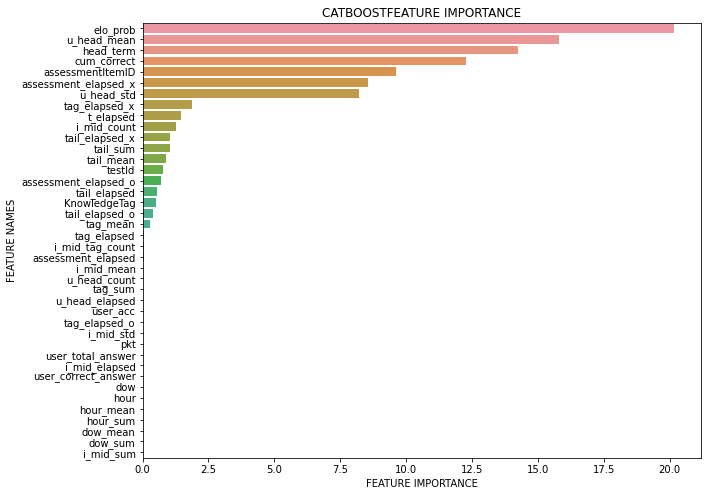

In [28]:
def plot_feature_importance(importance,names,model_type):
    from matplotlib import pyplot as plt
    import seaborn as sns
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


plot_feature_importance(model.get_feature_importance(),FEATS,'CATBOOST')

### Valid

In [11]:
cv_valid_data = pd.read_csv('/opt/ml/input/data/cv_valid_data.csv',dtype=dtype, parse_dates=['Timestamp'])
test_data = feature_engineering(cv_valid_data)

# test 데이터셋은 각 유저의 마지막 interaction만 추출
test_data = test_data[test_data['userID'] != test_data['userID'].shift(-1)]
test_data = test_data.drop(['answerCode'], axis=1)

preds = model.predict(test_data[FEATS], prediction_type='Probability')[:,1]

output_dir = 'output/'
write_path = os.path.join(output_dir, "catboost_valid.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(preds):
        w.write('{},{}\n'.format(id,p))       

KeyboardInterrupt: 

### Test

In [7]:
exp_day = str(date.today())

KST = timezone(timedelta(hours=9)); time_record = datetime.now(KST); _day = str(time_record)[:10]; _time = str(time_record.time())[:8]; now_time = _day+'_'+_time

test_data = pd.read_pickle('/opt/ml/level2-dkt-level2-recsys-08/data_pkl/test_data.pkl')
test_data = test_data[test_data['userID'] != test_data['userID'].shift(-1)]
test_data = test_data.drop(['answerCode'], axis=1)

preds = model.predict(test_data[FEATS] , prediction_type='Probability')[:,1]

output_dir = 'output/'
write_path = os.path.join(output_dir, f"catboost_test{now_time}.csv")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/catboost_test2022-05-07_11:21:56.csv


In [ ]:
test_data = pd.read_pickle('/opt/ml/level2-dkt-level2-recsys-08/data_pkl/test_data.pkl')
test_data